<a href="https://colab.research.google.com/github/SunnyJaneH/Text_Classification/blob/master/245_HW3_1_JH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub imbalanced-learn scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef, roc_auc_score,
    roc_curve, precision_recall_curve, auc, confusion_matrix
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings

warnings.filterwarnings('ignore')

# --- 1. Dataset Loading using Kaggle Hub ---

import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "indian_liver_patient.csv"

# Load the dataset using kagglehub
print(f"Attempting to load dataset 'uciml/indian-liver-patient-records' via Kaggle Hub...")
try:
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "uciml/indian-liver-patient-records",
        file_path
    )
    print("Dataset loaded successfully using Kaggle Hub.")
except Exception as e:
    print(f"Error loading dataset with Kaggle Hub: {e}")
    print("Please ensure 'kagglehub' is installed and you have network access.")

    import sys
    sys.exit(1)

print("\nFirst 5 records of the dataset:")
print(df.head())
print("\nDataset information:")
print(df.info())
print("\nMissing values check (initial):")
print(df.isnull().sum()) # Check for missing values

Attempting to load dataset 'uciml/indian-liver-patient-records' via Kaggle Hub...
Using Colab cache for faster access to the 'indian-liver-patient-records' dataset.
Dataset loaded successfully using Kaggle Hub.

First 5 records of the dataset:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3    

In [ ]:
# --- 2. Data Preprocessing and Feature Engineering for Indian Liver Patient Records ---

# Identify the target column
target_column = 'Dataset'

# Handle missing values
# Impute with the mean for numerical imputation.
df['Albumin_and_Globulin_Ratio'] = df['Albumin_and_Globulin_Ratio'].fillna(
    df['Albumin_and_Globulin_Ratio'].mean()
)
print("\nMissing values after imputation:")
print(df.isnull().sum())

# Handle categorical features
# 'Gender' column needs mapping to numerical
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}) # Map to numerical for simplicity

# Map target variable
# 'Dataset' column: 1 indicates liver patient, 2 indicates no liver patient.
# We map 1 -> 1 (positive class), 2 -> 0 (negative class).
df[target_column] = df[target_column].map({1: 1, 2: 0})

# Define features (X) and target (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Check target variable distribution
print(f"\nTarget variable '{target_column}' distribution (1=Liver Patient, 0=Non-Patient):")
print(y.value_counts())
print(y.value_counts(normalize=True)) # Proportions

# Data Split (Stratified split is crucial for imbalanced datasets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set features shape: {X_train.shape}")
print(f"Test set features shape: {X_test.shape}")
print(f"Training set target shape: {y_train.shape}")
print(f"Test set target shape: {y_test.shape}")
print(f"Training set '{target_column}' distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set '{target_column}' distribution:\n{y_test.value_counts(normalize=True)}")

# Scale numerical features (important for KNN and generally good for many ML algorithms)
scaler = StandardScaler()

# All remaining columns in X are features that need scaling.
numerical_cols = X_train.columns.tolist()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Ensure X_train_scaled and X_test_scaled are NumPy arrays for custom DT
X_train_np = X_train_scaled.values
X_test_np = X_test_scaled.values
y_train_np = y_train.values
y_test_np = y_test.values


Missing values after imputation:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

Target variable 'Dataset' distribution (1=Liver Patient, 0=Non-Patient):
Dataset
1    416
0    167
Name: count, dtype: int64
Dataset
1    0.713551
0    0.286449
Name: proportion, dtype: float64

Training set features shape: (408, 10)
Test set features shape: (175, 10)
Training set target shape: (408,)
Test set target shape: (175,)
Training set 'Dataset' distribution:
Dataset
1    0.713235
0    0.286765
Name: proportion, dtype: float64
Test set 'Dataset' distribution:
Dataset
1    0.714286
0    0.285714
Name: proportion, dtype: float64


In [ ]:
# --- 3. Oversampling Techniques ---

# 3.1 Random Oversampling
print("\n--- Applying Random Oversampling ---")
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)
print(f"Random Oversampling - Training set '{target_column}' distribution:\n{y_train_ros.value_counts(normalize=True)}")

# 3.2 SMOTE
print("\n--- Applying SMOTE Oversampling ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"SMOTE Oversampling - Training set '{target_column}' distribution:\n{y_train_smote.value_counts(normalize=True)}")


--- Applying Random Oversampling ---
Random Oversampling - Training set 'Dataset' distribution:
Dataset
1    0.5
0    0.5
Name: proportion, dtype: float64

--- Applying SMOTE Oversampling ---
SMOTE Oversampling - Training set 'Dataset' distribution:
Dataset
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# --- 4. Algorithm One: Decision Tree Classifier ---

class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None, probas=None):
        """
        Decision Tree Node structure.
        :param feature_idx: Index of the feature used for splitting at this node.
        :param threshold: Threshold value for the split.
        :param left: Left child node.
        :param right: Right child node.
        :param value: Predicted class label if this is a leaf node.
        :param probas: Probability distribution over classes if this is a leaf node.
        """
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.probas = probas # {class_label: probability}

class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        """
        Custom Decision Tree Classifier using Gini impurity.
        :param max_depth: The maximum depth of the tree.
        :param min_samples_split: The minimum number of samples required to split an internal node.
        :param min_samples_leaf: The minimum number of samples required to be at a leaf node.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.n_classes = None # Will be set during fit

    def _gini_impurity(self, y):
        """Calculates the Gini impurity for a set of labels."""
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def _best_split(self, X, y):
        """Finds the best feature and threshold to split the data."""
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None, None, None

        parent_gini = self._gini_impurity(y)
        best_info_gain = -1
        best_feature_idx = None
        best_threshold = None

        for feature_idx in range(n):
            # Use unique values as potential thresholds for numerical features
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold

                y_left, y_right = y[left_mask], y[right_mask]

                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                gini_left = self._gini_impurity(y_left)
                gini_right = self._gini_impurity(y_right)

                weight_left = len(y_left) / m
                weight_right = len(y_right) / m
                info_gain = parent_gini - (weight_left * gini_left + weight_right * gini_right)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_info_gain

    def _build_tree(self, X, y, depth=0):
        """Recursively builds the decision tree."""
        # Stop conditions: max depth, all samples are of one class, or not enough samples to split
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (len(np.unique(y)) == 1) or \
           (len(y) < self.min_samples_split):

            # Create a leaf node
            unique_classes, counts = np.unique(y, return_counts=True)
            probas = {cls: count / len(y) for cls, count in zip(unique_classes, counts)}

            # Ensure all class probabilities are present, even if 0
            for cls_val in range(self.n_classes):
                if cls_val not in probas:
                    probas[cls_val] = 0.0

            leaf_value = unique_classes[np.argmax(counts)]
            return Node(value=leaf_value, probas=probas)

        feature_idx, threshold, info_gain = self._best_split(X, y)

        if info_gain is None or info_gain <= 0: # If no good split found or no gain
            unique_classes, counts = np.unique(y, return_counts=True)
            probas = {cls: count / len(y) for cls, count in zip(unique_classes, counts)}
            for cls_val in range(self.n_classes):
                if cls_val not in probas:
                    probas[cls_val] = 0.0
            leaf_value = unique_classes[np.argmax(counts)]
            return Node(value=leaf_value, probas=probas)

        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold

        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_idx=feature_idx, threshold=threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        """Trains the decision tree classifier."""
        X_np = X if isinstance(X, np.ndarray) else X.values
        y_np = y if isinstance(y, np.ndarray) else y.values
        self.n_classes = len(np.unique(y_np)) # Determine number of classes
        self.tree = self._build_tree(X_np, y_np)

    def _traverse_tree(self, x, node):
        """Traverses the tree to make a prediction for a single sample."""
        if node.value is not None: # If it's a leaf node
            return node.value, node.probas

        # Handle cases where feature_idx might be out of bounds if X_test has fewer features
        if node.feature_idx >= len(x):
            # Fallback to majority class in current node if feature is missing
            return node.value, node.probas

        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        """Predicts class labels for input samples."""
        X_np = X if isinstance(X, np.ndarray) else X.values
        predictions = []
        for x_sample in X_np:
            pred_class, _ = self._traverse_tree(x_sample, self.tree)
            predictions.append(pred_class)
        return np.array(predictions)

    def predict_proba(self, X):
        """Predicts class probabilities for input samples."""
        X_np = X if isinstance(X, np.ndarray) else X.values
        probas_list = []
        for x_sample in X_np:
            _, probas_dict = self._traverse_tree(x_sample, self.tree)
            # Ensure output is a list/array of probabilities for each class in order (e.g., [P(0), P(1)])
            proba_class_0 = probas_dict.get(0, 0.0)
            proba_class_1 = probas_dict.get(1, 0.0)
            probas_list.append([proba_class_0, proba_class_1])
        return np.array(probas_list)

In [ ]:
# --- 5. Algorithm Two: K-Nearest Neighbors Classifier (using scikit-learn) ---
from sklearn.neighbors import KNeighborsClassifier


========== Scenario 1: Original Imbalanced Data ==========

Training Custom Decision Tree on Original Data...

--- Custom Decision Tree (Original Data) Performance Evaluation ---
Accuracy: 0.6514
Precision: 0.7462
Recall: 0.7760
F1-Score: 0.7608
Kappa: 0.1196
MCC: 0.1199
AUC-ROC: 0.5511
PR-AUC: 0.8231


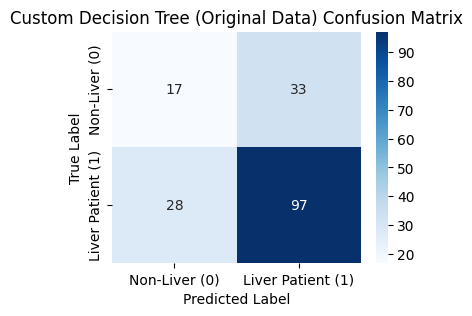

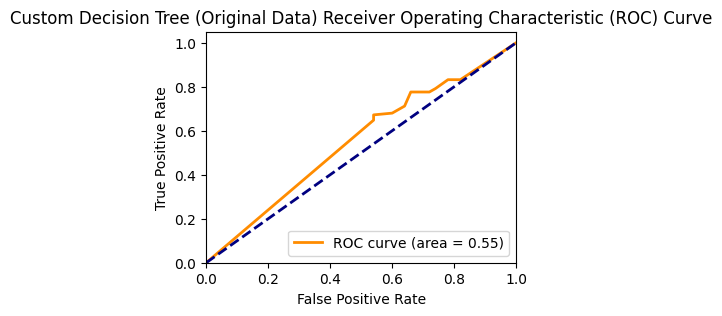

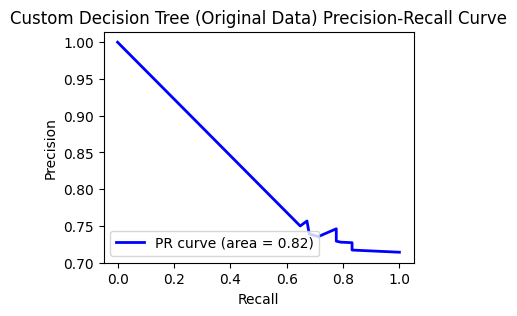


Training K-Nearest Neighbors on Original Data...

--- K-Nearest Neighbors (Original Data) Performance Evaluation ---
Accuracy: 0.6743
Precision: 0.7394
Recall: 0.8400
F1-Score: 0.7865
Kappa: 0.1114
MCC: 0.1155
AUC-ROC: 0.6661
PR-AUC: 0.8571


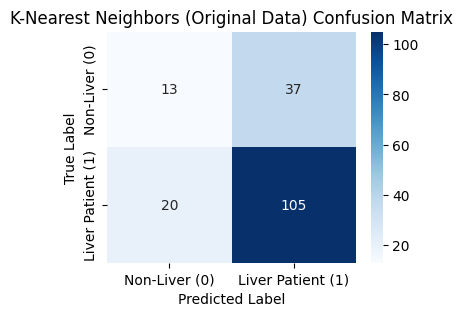

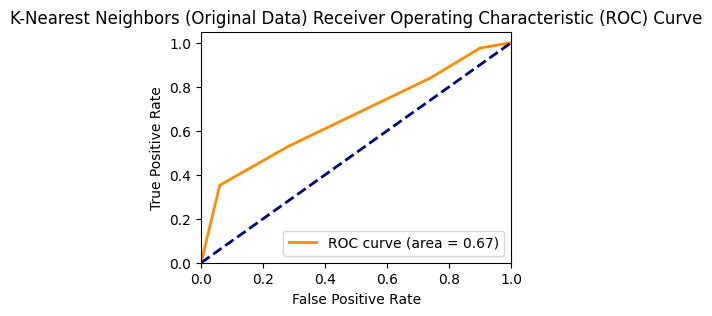

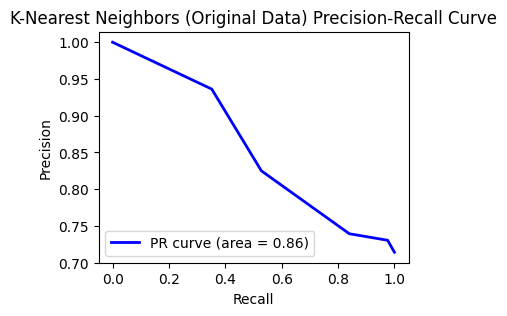


========== Scenario 2: Data with Random Oversampling ==========

Training Custom Decision Tree on Random Oversampled Data...

--- Custom Decision Tree (Random Oversampled) Performance Evaluation ---
Accuracy: 0.6457
Precision: 0.7405
Recall: 0.7760
F1-Score: 0.7578
Kappa: 0.0996
MCC: 0.1000
AUC-ROC: 0.6262
PR-AUC: 0.8516


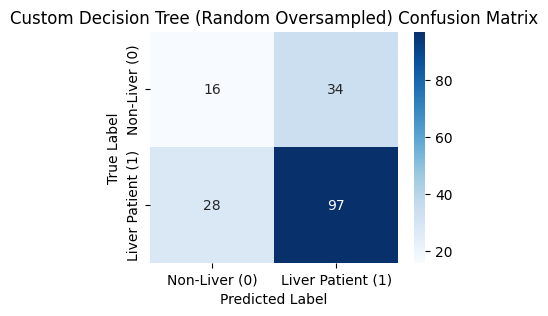

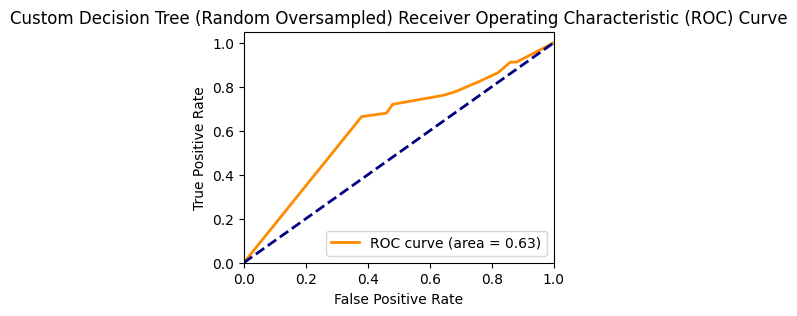

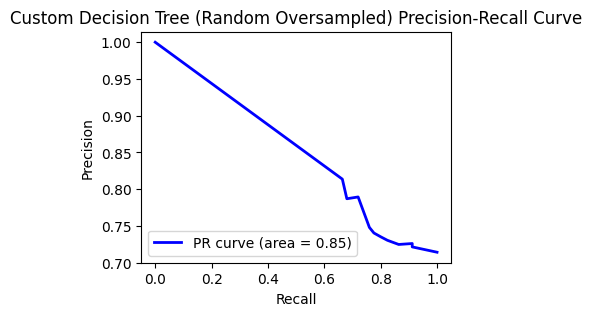


Training K-Nearest Neighbors on Random Oversampled Data...

--- K-Nearest Neighbors (Random Oversampled) Performance Evaluation ---
Accuracy: 0.5943
Precision: 0.7812
Recall: 0.6000
F1-Score: 0.6787
Kappa: 0.1533
MCC: 0.1634
AUC-ROC: 0.6819
PR-AUC: 0.8577


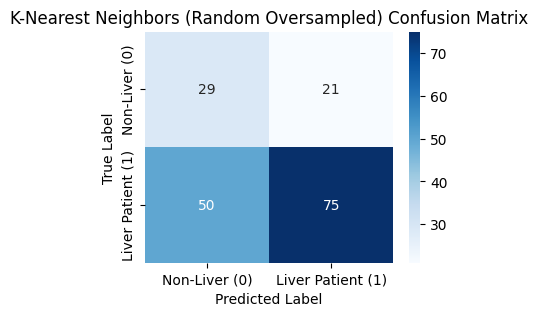

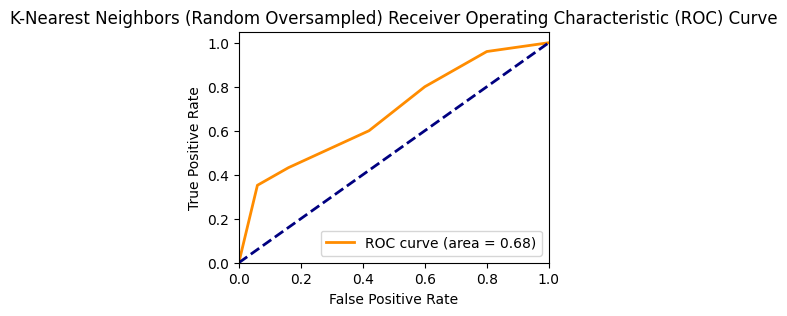

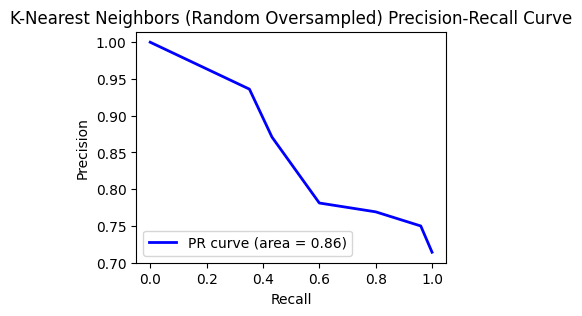


========== Scenario 3: Data with SMOTE Oversampling ==========

Training Custom Decision Tree on SMOTE Oversampled Data...

--- Custom Decision Tree (SMOTE Oversampled) Performance Evaluation ---
Accuracy: 0.6743
Precision: 0.8036
Recall: 0.7200
F1-Score: 0.7595
Kappa: 0.2597
MCC: 0.2635
AUC-ROC: 0.6327
PR-AUC: 0.8407


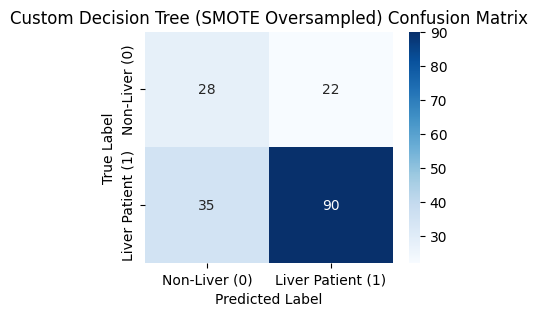

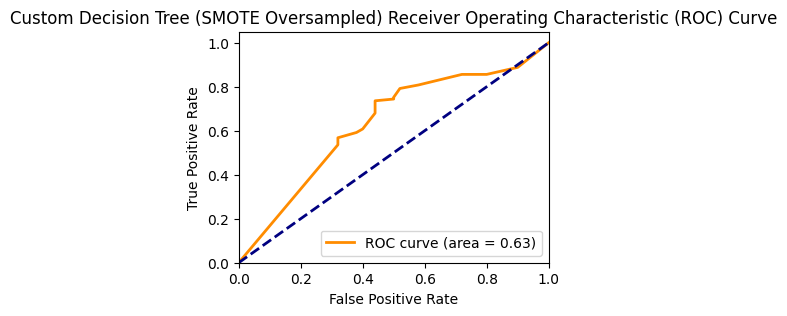

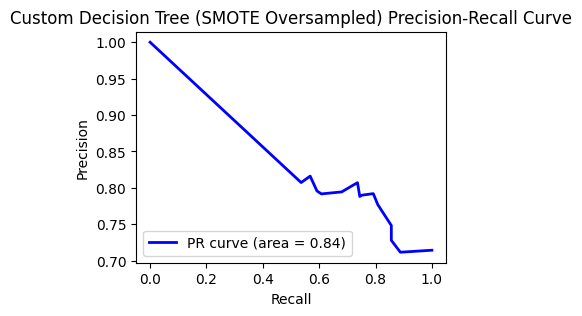


Training K-Nearest Neighbors on SMOTE Oversampled Data...

--- K-Nearest Neighbors (SMOTE Oversampled) Performance Evaluation ---
Accuracy: 0.6400
Precision: 0.8370
Recall: 0.6160
F1-Score: 0.7097
Kappa: 0.2638
MCC: 0.2859
AUC-ROC: 0.7254
PR-AUC: 0.8835


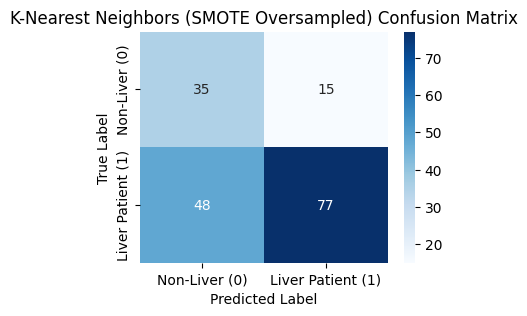

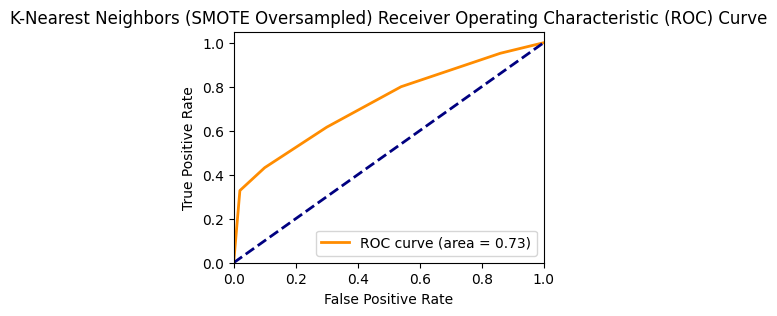

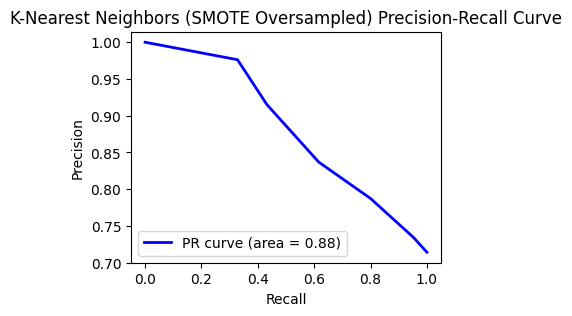

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import io
from IPython.display import display, Image, HTML
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors import KNeighborsClassifier

# --- 6. Evaluation Function ---

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """
    Evaluates a classification model, prints metrics, and visualizes plots.
    Plots are saved to memory and displayed as images for reliable PDF export.
    """
    print(f"\n--- {model_name} Performance Evaluation ---")

    # Basic Classification Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")

    # AUC-ROC
    roc_auc = roc_auc_score(y_true, y_proba[:, 1])
    print(f"AUC-ROC: {roc_auc:.4f}")

    # PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_proba[:, 1])
    pr_auc = auc(recall_vals, precision_vals)
    print(f"PR-AUC: {pr_auc:.4f}")

    # Calculate ROC curve components (needed for the plot)
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])

    # --- Visualizations: Save to Memory and Display as Image ---

    # Define all plot functions (lambda functions ensure delayed execution)
    plots = [
        # 1. Confusion Matrix Plot
        lambda: (
            sns.heatmap(
                confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Liver (0)', 'Liver Patient (1)'],
                yticklabels=['Non-Liver (0)', 'Liver Patient (1)']),
            plt.title(f'{model_name} Confusion Matrix'),
            plt.xlabel('Predicted Label'),
            plt.ylabel('True Label')
        ),

        # 2. ROC Curve Plot
        lambda: (
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'),
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'),
            plt.xlim([0.0, 1.0]),
            plt.ylim([0.0, 1.05]),
            plt.xlabel('False Positive Rate'),
            plt.ylabel('True Positive Rate'),
            plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve'),
            plt.legend(loc="lower right")
        ),

        # 3. Precision-Recall Curve Plot
        lambda: (
            plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})'),
            plt.xlabel('Recall'),
            plt.ylabel('Precision'),
            plt.title(f'{model_name} Precision-Recall Curve'),
            plt.legend(loc="lower left")
        )
    ]

    # Loop through plots: Draw, save, display, and force a page break
    for plot_func in plots:
        plt.figure(figsize=(4, 3))
        plot_func() # Execute the plotting logic

        # Save the figure to an in-memory buffer as a PNG image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close() # Close the figure to free up memory and prevent plt.show()
        buf.seek(0)

        # Explicitly display the saved image
        display(Image(data=buf.read(), format='png'))

        display(HTML('<div style="height: 5px; page-break-after: always;"></div>'))

    # Final page break after the model evaluation set is complete
    display(HTML('<div style="height: 10px; page-break-after: always;"></div>'))


# --- Model Training and Evaluation for Each Scenario ---

# Scenario 1: Original Imbalanced Data
print("\n========== Scenario 1: Original Imbalanced Data ==========")

# Train Custom Decision Tree
print("\nTraining Custom Decision Tree on Original Data...")
custom_dt_orig = CustomDecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=3)
custom_dt_orig.fit(X_train_np, y_train_np)
y_pred_dt_orig = custom_dt_orig.predict(X_test_np)
y_proba_dt_orig = custom_dt_orig.predict_proba(X_test_np)
evaluate_model(y_test_np, y_pred_dt_orig, y_proba_dt_orig, "Custom Decision Tree (Original Data)")

# Train KNN
print("\nTraining K-Nearest Neighbors on Original Data...")
knn_orig = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) # n_jobs=-1 uses all CPU cores
knn_orig.fit(X_train_scaled, y_train)
y_pred_knn_orig = knn_orig.predict(X_test_scaled)
y_proba_knn_orig = knn_orig.predict_proba(X_test_scaled)
evaluate_model(y_test_np, y_pred_knn_orig, y_proba_knn_orig, "K-Nearest Neighbors (Original Data)")


# Scenario 2: Data with Random Oversampling
print("\n========== Scenario 2: Data with Random Oversampling ==========")

# Convert to numpy arrays for custom DT
import pandas as pd
X_train_ros_np = X_train_ros.values if isinstance(X_train_ros, pd.DataFrame) else X_train_ros
y_train_ros_np = y_train_ros.values if isinstance(y_train_ros, pd.Series) else y_train_ros

# Train Custom Decision Tree on Random Oversampled Data
print("\nTraining Custom Decision Tree on Random Oversampled Data...")
custom_dt_ros = CustomDecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=3)
custom_dt_ros.fit(X_train_ros_np, y_train_ros_np)
y_pred_dt_ros = custom_dt_ros.predict(X_test_np) # Test on original test set
y_proba_dt_ros = custom_dt_ros.predict_proba(X_test_np)
evaluate_model(y_test_np, y_pred_dt_ros, y_proba_dt_ros, "Custom Decision Tree (Random Oversampled)")

# Train KNN on Random Oversampled Data
print("\nTraining K-Nearest Neighbors on Random Oversampled Data...")
knn_ros = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_ros.fit(X_train_ros, y_train_ros)
y_pred_knn_ros = knn_ros.predict(X_test_scaled)
y_proba_knn_ros = knn_ros.predict_proba(X_test_scaled)
evaluate_model(y_test_np, y_pred_knn_ros, y_proba_knn_ros, "K-Nearest Neighbors (Random Oversampled)")


# Scenario 3: Data with SMOTE Oversampling
print("\n========== Scenario 3: Data with SMOTE Oversampling ==========")

# Convert to numpy arrays for custom DT
X_train_smote_np = X_train_smote.values if isinstance(X_train_smote, pd.DataFrame) else X_train_smote
y_train_smote_np = y_train_smote.values if isinstance(y_train_smote, pd.Series) else y_train_smote

# Train Custom Decision Tree on SMOTE Oversampled Data
print("\nTraining Custom Decision Tree on SMOTE Oversampled Data...")
custom_dt_smote = CustomDecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=3)
custom_dt_smote.fit(X_train_smote_np, y_train_smote_np)
y_pred_dt_smote = custom_dt_smote.predict(X_test_np) # Test on original test set
y_proba_dt_smote = custom_dt_smote.predict_proba(X_test_np)
evaluate_model(y_test_np, y_pred_dt_smote, y_proba_dt_smote, "Custom Decision Tree (SMOTE Oversampled)")

# Train KNN on SMOTE Oversampled Data
print("\nTraining K-Nearest Neighbors on SMOTE Oversampled Data...")
knn_smote = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_smote.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn_smote.predict(X_test_scaled)
y_proba_knn_smote = knn_smote.predict_proba(X_test_scaled)
evaluate_model(y_test_np, y_pred_knn_smote, y_proba_knn_smote, "K-Nearest Neighbors (SMOTE Oversampled)")

**1.Conclusion**

Dataset: I used Liver Patient Prediction Results (https://www.kaggle.com/datasets/uciml/indian-liver-patient-records)

We tested two models:

*   Decision Trew
*   KNN

on the Liver Patient dataset with and without balancing the data (using Random Oversampling and SMOTE).

**2. Analysis**

**2.1 On the Original, Imbalanced Data**

Both models showed moderate Accuracy (around 65%–67%). The KNN model achieved the highest Recall (0.8400) among all scenarios, meaning it was best at correctly identifying actual liver patients when trained on the original skewed data. However, the low AUC-ROC (0.5511) for the CDT indicates it performed only marginally better than random guessing in distinguishing the classes.

**2.2 With Random Oversampling (ROS)**

ROS generally improved the AUC-ROC and PR-AUC for both models (e.g., KNN's AUC-ROC rose from 0.6661 to 0.6819), suggesting better separability between classes. However, this came at the cost of overall classification metrics:

KNN (ROS) saw its Recall drastically drop from 0.8400 to 0.6000, indicating it became much worse at catching true positive cases.

The overall Accuracy for KNN also dropped substantially to 0.5943.

**2.3 With SMOTE Oversampling (Best Overall Performer)**
SMOTE provided the most reliable and robust models:

KNN (SMOTE) emerged as the overall strongest performer, achieving the highest AUC-ROC (0.7254) and PR-AUC (0.8835). This indicates it is the best model for ranking predictions and distinguishing between positive and negative cases. It also achieved the highest MCC (0.2859), confirming its robust predictive quality across all classes.

CDT (SMOTE) achieved the best MCC (0.2635) and Accuracy (0.6743) among the Decision Tree variants, showing that SMOTE significantly stabilized the Decision Tree's performance compared to the original or ROS data.

**Discussion and Key Takeaways:**

1.KNN is Superior: The K-Nearest Neighbors (KNN) model consistently demonstrated better performance metrics (especially AUC-ROC and PR-AUC) than the Custom Decision Tree across all balancing scenarios.

2.SMOTE Provides Robustness: Using SMOTE oversampling was critical. While KNN on the original data had the highest Recall, the combination of KNN + SMOTE yielded the best scores for AUC-ROC (0.7254) and MCC (0.2859). These metrics are crucial in medical contexts because they measure the model's overall reliability and ability to discriminate between the two classes.

3.The Trade-off: The high Recall seen in the Original KNN model (0.8400) comes with the risk of being overly aggressive due to data imbalance, potentially leading to more false positives. SMOTE sacrifices some Recall (dropping to 0.6160) but achieves the highest Precision (0.8370) for the KNN model, meaning when it does predict a patient is positive, it's highly likely to be correct. This balance is often preferred.

For this dataset, K-Nearest Neighbors combined with SMOTE oversampling is the best choice. It provides the most reliable distinction between classes, resulting in the most robust and trustworthy predictions for identifying liver patients.